In [1]:
# biblioteki
!pip install pandas matplotlib --quiet
!pip install tensorflow --quiet
!pip install mlxtend --upgrade --no-deps --quiet

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlxtend

from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam

from platform import python_version


print(f"""
    PYTHON VERSION:      {python_version()}
    NUMPY VERSION:       {np.__version__}
    PANDAS VERSION:      {pd.__version__}
    TENSERFLOW VERSION:  {tf.__version__}
    KERAS VERSION:       {keras.__version__}
    MLEXTEND VERSION:    {mlxtend.__version__}
""")

2022-05-18 15:56:14.007606: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-18 15:56:14.007653: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



    PYTHON VERSION:      3.8.10
    NUMPY VERSION:       1.22.3
    PANDAS VERSION:      1.4.2
    TENSERFLOW VERSION:  2.8.0
    KERAS VERSION:       2.8.0
    MLEXTEND VERSION:    0.19.0



In [2]:
# CONSTANTS
C_GREYSCALE = False
C_IMG_SIZE = 128
C_IMG_CHANNELS = 1

In [3]:
from PIL import Image, ImageOps

def load_image(path: str, filename: str, reshape: tuple = (), greyscale: bool = False, normalize: bool = False):
    og_image = Image.open(f"{path}/{filename}")
    
    if reshape:
        og_image = og_image.resize(reshape)
        
    if greyscale:
        og_image = ImageOps.grayscale(og_image)
    
    return np.array(og_image.getdata(), dtype=int)


print(load_image(f'CelebAMask-HQ/CelebA-HQ-img', f'1.jpg', greyscale = C_GREYSCALE, reshape = (C_IMG_SIZE, C_IMG_SIZE)))

[[183 183 185]
 [185 185 187]
 [184 184 186]
 ...
 [160 125  80]
 [163 125  77]
 [169 134  89]]


In [15]:
def plot_image(pixels: np.ndarray, shape = (1024, 1024, 3)) -> None:
    pixels = np.reshape(pixels, shape)
    plt.imshow(pixels, cmap='gray')

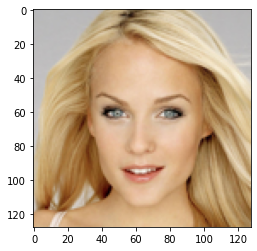

In [16]:
image = load_image(
    f'CelebAMask-HQ/CelebA-HQ-img', f'1.jpg',
    greyscale = C_GREYSCALE, 
    reshape = (C_IMG_SIZE, C_IMG_SIZE)
)
plot_image(image, (C_IMG_SIZE, C_IMG_SIZE, C_IMG_CHANNELS))

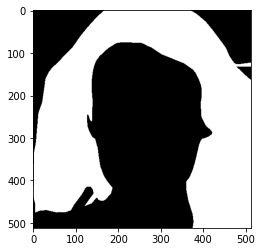

In [17]:
image = load_image(f'CelebAMask-HQ/CelebAMask-HQ-mask-anno/0', f'00001_hair.png')
plot_image(image, (512, 512, 3))

In [7]:
%%time
import os
from IPython.display import clear_output

def load_dataset(path: str, limit: int = None, reshape: tuple = (), greyscale: bool = False, normalize: bool = False):
    arrays = []
    subjects = list(set(map(lambda file: file.split('.')[0], os.listdir(f'{path}/CelebA-HQ-img'))))
    subjects.sort(key = int)
    if limit is not None:
        subjects = subjects[:limit]
    for subject in subjects:
        print(subject)
        clear_output(wait=True)
        try:
            arrays.append([
                load_image(f'{path}/CelebAMask-HQ-mask-anno/0', f'{subject:0>5}_hair.png', greyscale=greyscale, reshape=reshape), 
                load_image(f'{path}/CelebA-HQ-img', f'{subject}.jpg', greyscale=greyscale, reshape=reshape)
            ])
        except FileNotFoundError:
            pass
    return np.array(arrays, dtype=object)
    
dataset = load_dataset('CelebAMask-HQ', 1000, reshape=(C_IMG_SIZE, C_IMG_SIZE), greyscale=C_GREYSCALE)
print(len(dataset))

988
CPU times: user 46.8 s, sys: 1.45 s, total: 48.2 s
Wall time: 48.8 s


In [7]:
np.save('dataX1000x128x128x1.npy', dataset) # save

NameError: name 'dataset' is not defined

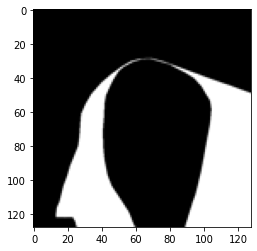

In [19]:
data = np.load('dataX1000x128x128x1.npy', allow_pickle=True)
# print(data[:, 1].tolist())
# data2d = pd.DataFrame({'HairMask': data[:, 0].tolist(), 'Pixels': data[:, 1].tolist()})

plot_image(data[6].tolist()[0], (C_IMG_SIZE, C_IMG_SIZE, 1))

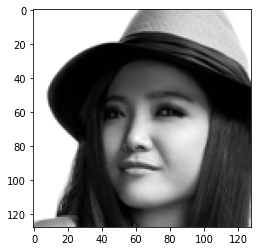

In [22]:
plot_image(data[6].tolist()[1], (C_IMG_SIZE, C_IMG_SIZE, C_IMG_CHANNELS))

In [23]:
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [24]:
def unet_model():
    img_size = C_IMG_SIZE
    img_channels = C_IMG_CHANNELS
    inputs = Input((img_size, img_size, img_channels))
    s = Lambda(lambda x: x)(inputs)
    
    # DOWN SAMPLING
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(s)
    c1 = Dropout(0.3)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Dropout(0.3)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Dropout(0.3)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # BOTTOM OF U-NET
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    
    # UP SAMPLING
    u6 = Conv2DTranspose(img_size, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(img_size >> 1, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)   
    
    u8 = Conv2DTranspose(img_size >> 2, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = Conv2DTranspose(img_size >> 3, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    print(model.summary())
    
    return model

model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])

2022-05-18 15:45:23.377844: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-18 15:45:23.377894: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-18 15:45:23.377926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bartosz-ubuntu): /proc/driver/nvidia/version does not exist
2022-05-18 15:45:23.378346: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  320         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

                                                                                                  
 conv2d_17 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_16[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 1)  33          ['conv2d_17[0][0]']              
                                                                                                  
Total params: 7,019,441
Trainable params: 7,019,441
Non-trainable params: 0
__________________________________________________________________________________________________
None


In [ ]:
# tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

epochs = 50
images = data[:, 0]
images = images.reshape((images.shape[0], 128, 128, 1))
images = np.asarray(images).astype('float32')
images = images/255
    
masks = data[:, 1]
masks = masks.reshape((masks.shape[0], 128, 128, 1))
masks = np.asarray(masks).astype('float32')
masks = masks/255

history = model.fit(images, masks, validation_split=0.1, epochs=epochs, batch_size=25)
model.save('model.h5')

Epoch 1/50


/home/bartosz/studia/processing/venv/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


17/18 [===========================>..] - ETA: 21s - loss: -289638816187154432.0000 - acc: 0.0043